In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [53]:
df = pd.read_csv("../../data/csv_files/df_ph1.csv")

In [55]:
df.shape

(7748, 10)

In [57]:
df['dt'] = pd.to_datetime(df['dt'])

In [59]:
stations = list(df.columns)
stations.remove('dt')

In [61]:
start_array = []
end_array = []
index = 3
start_na = True
print(stations[index])

for _, row in df.iterrows():
    if pd.isna(row[stations[index]]) and start_na:
        start_na = False
        start_array.append(row['dt'])
    elif not pd.isna(row[stations[index]]) and not start_na:
        start_na = True
        end_array.append(row['dt'])

FSB_126


In [63]:
print(len(start_array), len(end_array))

85 85


In [65]:
start_end = {}
for start, end in zip(start_array, end_array):
    start_end[start] = end
print(len(start_end))

85


In [67]:
length = {}
for start, end in start_end.items():
    length[(start, end)] = pd.to_datetime(end) - pd.to_datetime(start)
print(len(length))

85


In [69]:
na_data = {}
for key, duration in length.items():
    if duration > pd.Timedelta(days=1):
        na_data[key] = duration
print(len(na_data))
na_data

10


{(Timestamp('2023-07-28 08:00:00'),
  Timestamp('2023-07-31 13:00:00')): Timedelta('3 days 05:00:00'),
 (Timestamp('2023-07-31 14:00:00'),
  Timestamp('2023-08-03 22:00:00')): Timedelta('3 days 08:00:00'),
 (Timestamp('2023-08-04 07:00:00'),
  Timestamp('2023-08-08 04:00:00')): Timedelta('3 days 21:00:00'),
 (Timestamp('2023-08-09 11:00:00'),
  Timestamp('2023-08-13 16:00:00')): Timedelta('4 days 05:00:00'),
 (Timestamp('2023-08-13 20:00:00'),
  Timestamp('2023-08-19 05:00:00')): Timedelta('5 days 09:00:00'),
 (Timestamp('2023-08-19 09:00:00'),
  Timestamp('2023-08-21 19:00:00')): Timedelta('2 days 10:00:00'),
 (Timestamp('2023-08-23 20:00:00'),
  Timestamp('2023-08-28 16:00:00')): Timedelta('4 days 20:00:00'),
 (Timestamp('2023-08-28 17:00:00'),
  Timestamp('2023-08-31 07:00:00')): Timedelta('2 days 14:00:00'),
 (Timestamp('2023-08-31 22:00:00'),
  Timestamp('2023-10-18 14:45:00')): Timedelta('47 days 16:45:00'),
 (Timestamp('2024-01-01 01:00:00'),
  Timestamp('2024-01-24 14:06:00')):

In [71]:
new_df = df[df['dt'] >= "2024-01-24 17:00:00"]
print(new_df.shape)

(3390, 10)


In [73]:
new_df.isna().sum()

dt             0
FEX_004       21
FSB_095DR     21
FSB_078       21
FSB_126       32
FSB_130D      21
FPZ_06A       22
FSB_079       21
FPZ_04A       21
FSB_097D     186
dtype: int64

In [75]:
df_interpolate = new_df.copy()
for col in stations:
    df_interpolate[col] = df_interpolate[col].interpolate()

In [77]:
test_df = df_interpolate.drop(columns = ["dt"])
test_df.shape

(3390, 9)

In [79]:
test_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4358,4.200342,4.336478,4.332603,4.391724,4.334914,NaN,7.767760,7.494180,3.997277
4359,4.199731,4.336892,4.328062,4.392499,4.335384,5.250169,7.768929,7.495040,3.997087
4360,4.200343,4.336161,4.327713,4.392068,4.335722,5.256137,7.768003,7.493386,3.996909
4361,4.200376,4.336316,4.328190,4.391214,4.335845,5.261071,7.767725,7.497791,3.997079
4362,4.201028,4.335628,4.327332,4.389647,4.335733,5.264223,7.767564,7.495985,3.997174


In [81]:
test_df = test_df.fillna(5.243915)

In [83]:
test_df.isna().sum()

FEX_004      0
FSB_095DR    0
FSB_078      0
FSB_126      0
FSB_130D     0
FPZ_06A      0
FSB_079      0
FPZ_04A      0
FSB_097D     0
dtype: int64

In [85]:
# Flattening the dataframe
flat_array = test_df.values.flatten()
len(flat_array)

30510

In [87]:
# reshaping to 90 columns
reshaped_array = flat_array.reshape(-1,90)

In [89]:
new_df = pd.DataFrame(reshaped_array)

In [91]:
new_df.shape

(339, 90)

In [93]:
scaler = StandardScaler()
normalized_df = scaler.fit_transform(new_df)

In [95]:
tensor_data = torch.tensor(normalized_df, dtype=torch.float32)

dataset = TensorDataset(tensor_data, tensor_data)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [97]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 60),  
            nn.ReLU(),
            nn.Linear(60, 45),        
            nn.ReLU(),
            nn.Linear(45, 30),        
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 45),         
            nn.ReLU(),
            nn.Linear(45, 60),        
            nn.ReLU(),
            nn.Linear(60, input_dim), 
            nn.Sigmoid()               
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [99]:
input_dim = normalized_df.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [101]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.2630
Epoch [2/100], Loss: 1.2265
Epoch [3/100], Loss: 1.0587
Epoch [4/100], Loss: 1.2410
Epoch [5/100], Loss: 1.1654
Epoch [6/100], Loss: 1.0503
Epoch [7/100], Loss: 0.7570
Epoch [8/100], Loss: 0.6955
Epoch [9/100], Loss: 0.8535
Epoch [10/100], Loss: 0.7946
Epoch [11/100], Loss: 0.6194
Epoch [12/100], Loss: 0.8196
Epoch [13/100], Loss: 0.7306
Epoch [14/100], Loss: 0.8752
Epoch [15/100], Loss: 0.8097
Epoch [16/100], Loss: 0.9457
Epoch [17/100], Loss: 0.7431
Epoch [18/100], Loss: 0.6307
Epoch [19/100], Loss: 0.6373
Epoch [20/100], Loss: 0.6706
Epoch [21/100], Loss: 0.7145
Epoch [22/100], Loss: 0.6682
Epoch [23/100], Loss: 0.4920
Epoch [24/100], Loss: 0.5392
Epoch [25/100], Loss: 0.8902
Epoch [26/100], Loss: 0.4959
Epoch [27/100], Loss: 0.8195
Epoch [28/100], Loss: 0.5321
Epoch [29/100], Loss: 0.5389
Epoch [30/100], Loss: 0.6689
Epoch [31/100], Loss: 0.8052
Epoch [32/100], Loss: 0.6076
Epoch [33/100], Loss: 0.6065
Epoch [34/100], Loss: 0.7393
Epoch [35/100], Loss: 0

In [105]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(tensor_data)
    reconstruction_error = torch.mean((tensor_data - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))

339


In [107]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
threshold

1.5703457593917847

In [109]:
anomalies = reconstruction_error > threshold
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 24


In [111]:
reconstructed_data

tensor([[4.6351e-08, 5.2427e-07, 1.1046e-06,  ..., 9.8089e-20, 4.1940e-15,
         1.3827e-05],
        [4.2045e-08, 5.1551e-07, 9.0767e-07,  ..., 7.0900e-20, 3.1125e-15,
         1.3041e-05],
        [4.4723e-08, 4.6353e-07, 1.4164e-06,  ..., 8.3652e-20, 4.4728e-15,
         1.3182e-05],
        ...,
        [9.9583e-01, 1.0000e+00, 2.4718e-13,  ..., 9.9991e-01, 7.2614e-01,
         9.9993e-01],
        [9.9716e-01, 1.0000e+00, 7.6574e-14,  ..., 9.9995e-01, 5.9589e-01,
         9.9995e-01],
        [9.9736e-01, 1.0000e+00, 6.4158e-14,  ..., 9.9995e-01, 5.8436e-01,
         9.9995e-01]])

In [113]:
numpy_array = reconstructed_data.numpy()
numpy_array.shape

(339, 90)

In [115]:
predicted_df = pd.DataFrame(numpy_array)
predicted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,4.635122e-08,5.242733e-07,1.104601e-06,9.868406e-09,1.735709e-20,8.521018e-12,4.939203e-19,1.481996e-16,0.000008,0.000002,...,0.000012,1.013533e-06,0.000040,4.179126e-07,2.360587e-10,1.124959e-25,7.116048e-23,9.808920e-20,4.194048e-15,0.000014
1,4.204458e-08,5.155126e-07,9.076735e-07,8.869787e-09,1.226700e-20,5.937644e-12,3.624781e-19,1.103286e-16,0.000008,0.000002,...,0.000011,9.461219e-07,0.000040,3.463273e-07,2.049631e-10,7.251463e-26,4.412643e-23,7.090019e-20,3.112522e-15,0.000013
2,4.472338e-08,4.635268e-07,1.416435e-06,8.922302e-09,1.617032e-20,1.114090e-11,4.417166e-19,1.498820e-16,0.000008,0.000002,...,0.000011,9.647264e-07,0.000035,5.325512e-07,2.073435e-10,1.021739e-25,7.581209e-23,8.365246e-20,4.472774e-15,0.000013
3,4.067103e-08,4.628038e-07,1.160292e-06,7.618821e-09,1.055527e-20,7.094838e-12,2.947781e-19,1.064778e-16,0.000008,0.000002,...,0.000010,8.948081e-07,0.000035,4.510644e-07,1.748884e-10,5.979745e-26,4.084252e-23,5.351950e-20,3.198401e-15,0.000012
4,4.201724e-08,4.604067e-07,1.297118e-06,7.813180e-09,1.182310e-20,8.329298e-12,3.199139e-19,1.214402e-16,0.000008,0.000002,...,0.000011,9.154296e-07,0.000034,5.023418e-07,1.803202e-10,6.925600e-26,4.829068e-23,5.793707e-20,3.656690e-15,0.000013


In [117]:
test_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4358,4.200342,4.336478,4.332603,4.391724,4.334914,5.243915,7.767760,7.494180,3.997277
4359,4.199731,4.336892,4.328062,4.392499,4.335384,5.250169,7.768929,7.495040,3.997087
4360,4.200343,4.336161,4.327713,4.392068,4.335722,5.256137,7.768003,7.493386,3.996909
4361,4.200376,4.336316,4.328190,4.391214,4.335845,5.261071,7.767725,7.497791,3.997079
4362,4.201028,4.335628,4.327332,4.389647,4.335733,5.264223,7.767564,7.495985,3.997174


In [119]:
reversed_df = pd.DataFrame(scaler.inverse_transform(predicted_df), columns=predicted_df.columns)
reversed_df

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,4.295360,4.414905,4.366243,4.437210,4.413437,5.18225,7.630953,7.512500,4.083996,4.295420,...,4.084414,4.295856,4.415290,4.366302,4.437558,4.414546,5.18331,7.631305,7.511964,4.084491
1,4.295360,4.414905,4.366243,4.437210,4.413437,5.18225,7.630953,7.512500,4.083996,4.295420,...,4.084414,4.295856,4.415290,4.366302,4.437558,4.414546,5.18331,7.631305,7.511964,4.084491
2,4.295360,4.414905,4.366243,4.437210,4.413437,5.18225,7.630953,7.512500,4.083996,4.295420,...,4.084414,4.295856,4.415289,4.366302,4.437558,4.414546,5.18331,7.631305,7.511964,4.084491
3,4.295360,4.414905,4.366243,4.437210,4.413437,5.18225,7.630953,7.512500,4.083996,4.295420,...,4.084414,4.295856,4.415289,4.366302,4.437558,4.414546,5.18331,7.631305,7.511964,4.084491
4,4.295360,4.414905,4.366243,4.437210,4.413437,5.18225,7.630953,7.512500,4.083996,4.295420,...,4.084414,4.295856,4.415289,4.366302,4.437558,4.414546,5.18331,7.631305,7.511964,4.084491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,4.348422,4.463537,4.366243,4.463248,4.476644,5.18225,7.731133,7.610757,4.140083,4.348670,...,4.140468,4.349036,4.463882,4.366302,4.463590,4.479648,5.18331,7.732045,7.617385,4.140542
335,4.348474,4.463537,4.366243,4.463248,4.476644,5.18225,7.731137,7.608570,4.140085,4.348701,...,4.140468,4.349076,4.463882,4.366302,4.463590,4.479648,5.18331,7.732047,7.614795,4.140543
336,4.348519,4.463537,4.366243,4.463248,4.476644,5.18225,7.731122,7.598088,4.140088,4.348735,...,4.140468,4.349124,4.463882,4.366302,4.463590,4.479647,5.18331,7.732044,7.598010,4.140543
337,4.348589,4.463537,4.366243,4.463249,4.476644,5.18225,7.731138,7.584583,4.140090,4.348760,...,4.140468,4.349158,4.463882,4.366302,4.463590,4.479647,5.18331,7.732048,7.582575,4.140544


In [121]:
flat_array = reversed_df.values.flatten()
len(flat_array)

30510

In [123]:
reshaped_array = flat_array.reshape(-1,9)

In [125]:
predicted_df = pd.DataFrame(reshaped_array)
predicted_df.shape

(3390, 9)

In [127]:
index_station = {}
for index, station in enumerate(stations):
    index_station[index] = station

index_station


{0: 'FEX_004',
 1: 'FSB_095DR',
 2: 'FSB_078',
 3: 'FSB_126',
 4: 'FSB_130D',
 5: 'FPZ_06A',
 6: 'FSB_079',
 7: 'FPZ_04A',
 8: 'FSB_097D'}

In [129]:
predicted_df.head()

,0,1,2,3,4,5,6,7,8
0,4.295360,4.414905,4.366243,4.437210,4.413437,5.182250,7.630953,7.512500,4.083996
1,4.295420,4.414919,4.366231,4.437243,4.413604,5.182099,7.631060,7.512359,4.084047
2,4.295499,4.414970,4.366527,4.437289,4.413696,5.181816,7.631057,7.514640,4.084108
3,4.295578,4.414989,4.366298,4.437247,4.414291,5.181391,7.631104,7.513200,4.084157
4,4.295586,4.415038,4.366473,4.437316,4.414574,5.180855,7.631253,7.512595,4.084191


In [131]:
predicted_df.rename(columns=index_station, inplace=True)

In [133]:
predicted_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,4.295360,4.414905,4.366243,4.437210,4.413437,5.182250,7.630953,7.512500,4.083996
1,4.295420,4.414919,4.366231,4.437243,4.413604,5.182099,7.631060,7.512359,4.084047
2,4.295499,4.414970,4.366527,4.437289,4.413696,5.181816,7.631057,7.514640,4.084108
3,4.295578,4.414989,4.366298,4.437247,4.414291,5.181391,7.631104,7.513200,4.084157
4,4.295586,4.415038,4.366473,4.437316,4.414574,5.180855,7.631253,7.512595,4.084191


In [135]:
test_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4358,4.200342,4.336478,4.332603,4.391724,4.334914,5.243915,7.767760,7.494180,3.997277
4359,4.199731,4.336892,4.328062,4.392499,4.335384,5.250169,7.768929,7.495040,3.997087
4360,4.200343,4.336161,4.327713,4.392068,4.335722,5.256137,7.768003,7.493386,3.996909
4361,4.200376,4.336316,4.328190,4.391214,4.335845,5.261071,7.767725,7.497791,3.997079
4362,4.201028,4.335628,4.327332,4.389647,4.335733,5.264223,7.767564,7.495985,3.997174


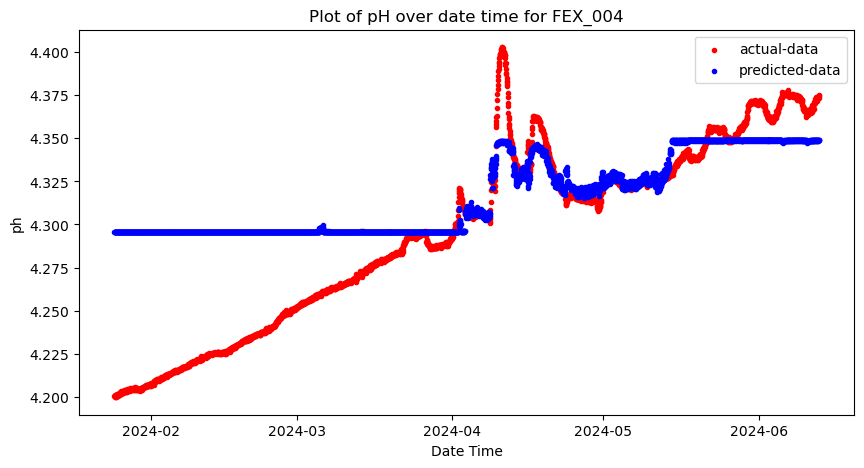

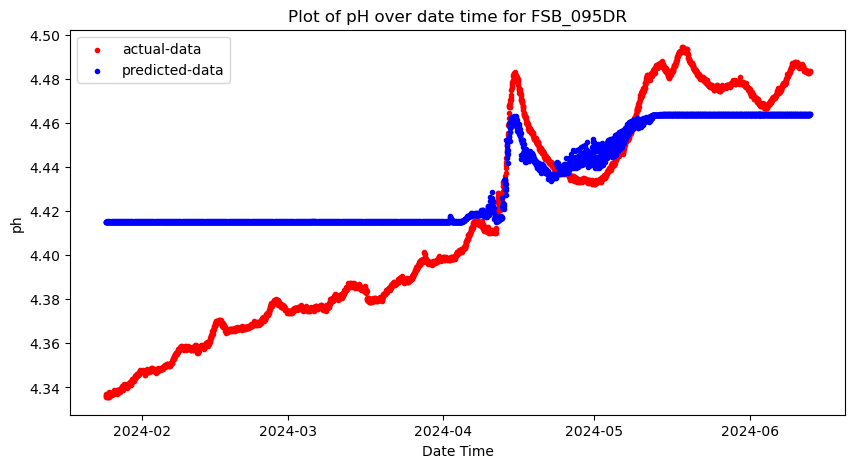

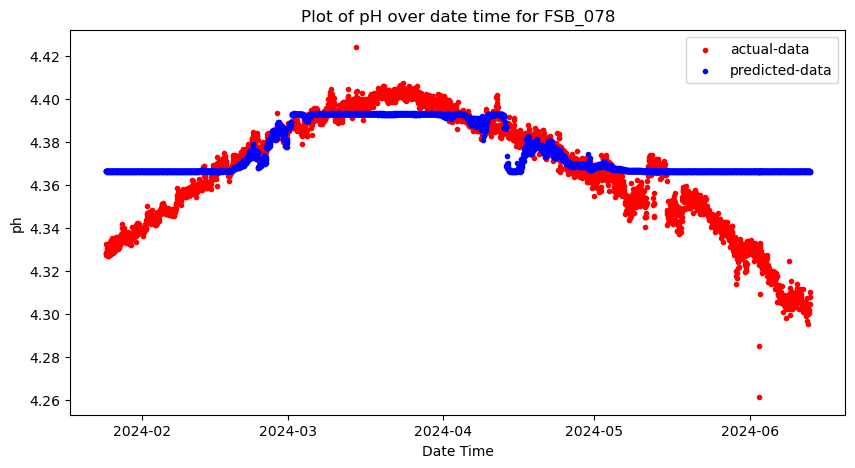

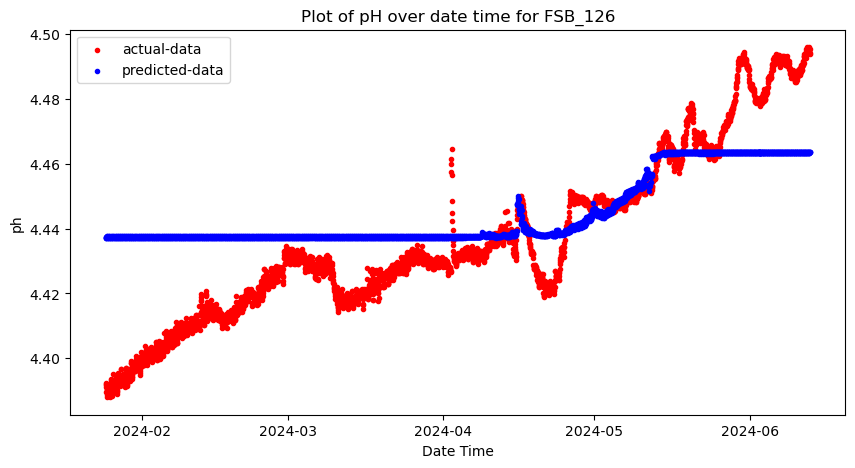

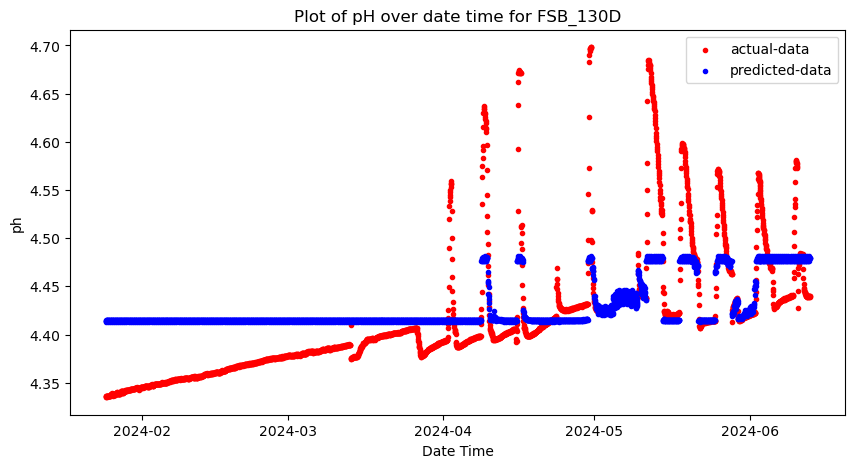

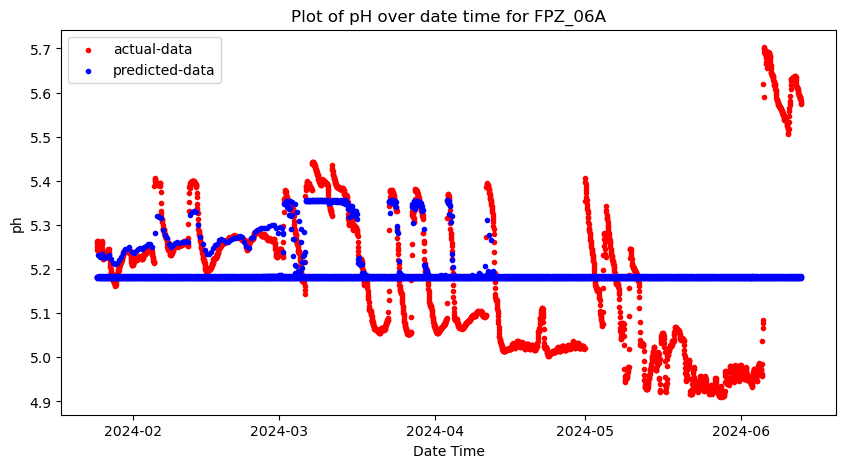

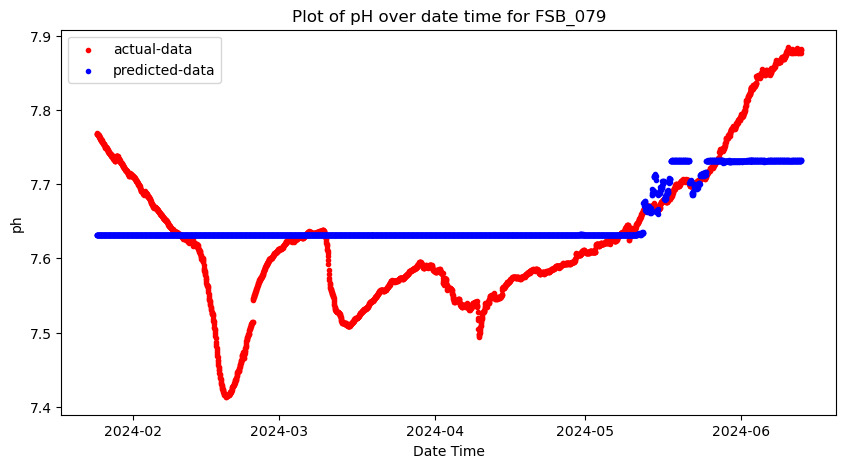

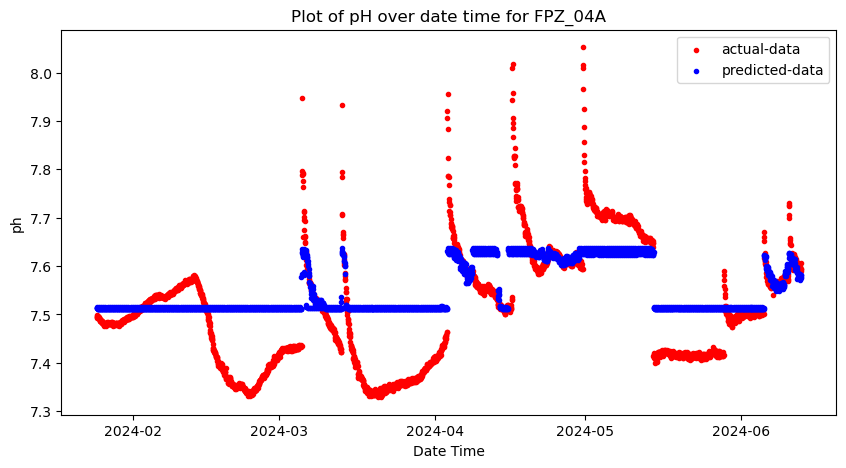

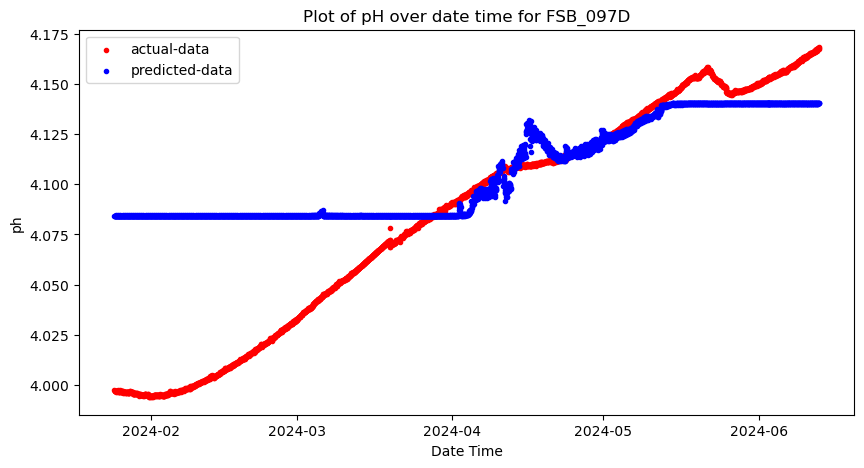

In [137]:
for index,station in enumerate(stations):
    
    plt.figure(figsize=(10, 5))
    # index = 0
    plt.scatter(df_interpolate["dt"], test_df[stations[index]], marker='.', color="red", label="actual-data")
    plt.scatter(df_interpolate["dt"], predicted_df[stations[index]], marker='.', color="blue", label = "predicted-data")


    plt.xlabel('Date Time')
    plt.ylabel('ph')
    plt.title(f'Plot of pH over date time for {stations[index]}')
    plt.legend()
    plt.show()